<a href="https://colab.research.google.com/github/sarthakkapila/Learning-AI/blob/main/AutoGradEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an AutoGrad (automatic Differentiation) Engine from scratch

In [101]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Lets look at derivatives first

In [102]:
def f(x):
  return 3**x + 4*x + 5

In [103]:
f(3.0)

44.0

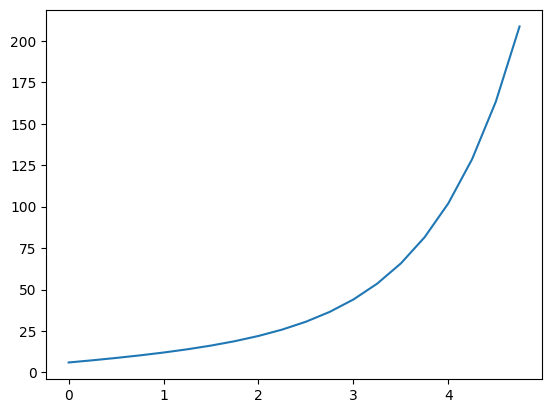

In [104]:
xs = np.arange(0,5,0.25)
ys = f(xs)

plt.plot(xs,ys)

In [105]:
# Where h -> infinity
h = 0.000001
x = 3.0
# Where this will represent the slope
(f(x) + h) - f(x)/h


-43999955.999999

### Now we aim to Transform this stuff to handle big data

In [106]:
class Value:

  def __init__(self, data, _children=(), _op='', label = ''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self._backward = lambda: None


#  returns a string that represents the object's state
  def __repr__(self):
    return f"{self.data}"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __sub__(self,other):
    out = Value(self.data - other.data, (self,other), '*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out_backward = _backward

    return out


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

-8.0

In [107]:
d._prev, d._op


({-6.0, 10.0}, '+')

Visualize

In [108]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

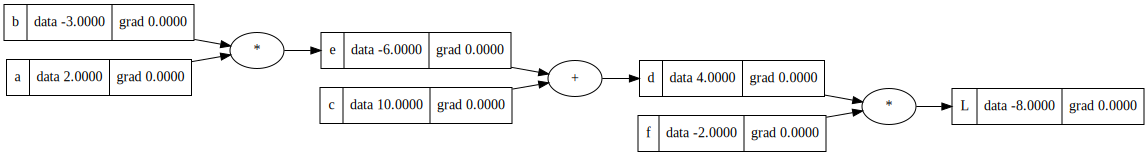

In [109]:
draw_dot(L)

In [110]:
L = d * f

### dL/dd = f

(f(x+h) - f(x))/h where h->infinty

((d+h)*f - d*f)/h

(d*f + h*f - d*f)/h

(h*f)/h

f

In [111]:
# a.data += 0.01 * a.grad
# b.data += 0.01 * b.grad
# c.data += 0.01 * c.grad
# f.data += 0.01 * f.grad

# e = a * b
# d = e + c
# L = d * f

# print(L.data)

In [112]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  c.data += h
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-1.9999999999988916


In [113]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

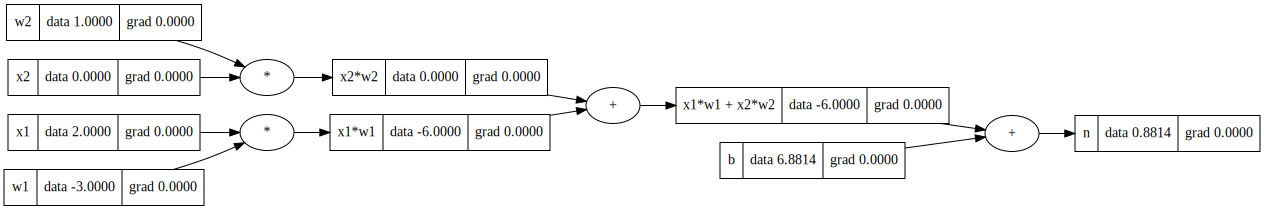

In [114]:
draw_dot(n)

In [115]:
o.grad = 1.0
o._backward()

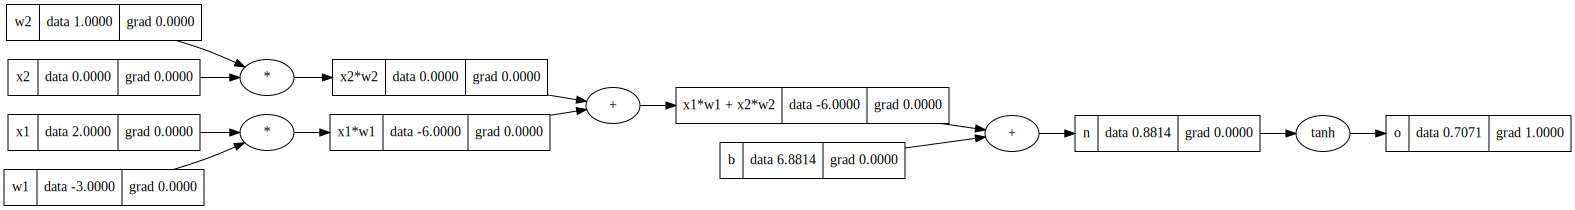

In [116]:
draw_dot(o)